In [1]:
import sys
import time
import random
from os.path import exists
from typing import *

# Common data science imports
import numpy as np
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.cluster import KMeans

# Visualization tools
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from seaborn import heatmap
from tqdm import tqdm, notebook as tqdm_notebook

# GPyTorch and linear_operator imports
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.constraints import *
import linear_operator
from linear_operator.settings import max_cholesky_size
from linear_operator.operators.dense_linear_operator import DenseLinearOperator
from linear_operator.utils.cholesky import psd_safe_cholesky

# Custom soft GP and MLL imports
from gp.soft_gp.soft_gp import SoftGP
from gp.soft_gp.mll import HutchinsonPseudoLoss
from linear_solver.cg import linear_cg

# Data analysis and UCI dataset

# Utility functions for dataset handling
from gp.util import flatten_dataset, split_dataset, filter_param

# Experiment tracking
import wandb

# System path adjustments
sys.path.append("../")

In [2]:
def eval_gp(model, test_dataset: Dataset, device="cuda:0") -> float:
    preds = []
    neg_mlls = []
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=1)
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds += [(model.pred(x_batch) - y_batch).detach().cpu()**2]
        neg_mlls += [-model.mll(x_batch, y_batch).detach().cpu()]
    rmse = torch.sqrt(torch.sum(torch.cat(preds)) / len(test_dataset)).item()
    neg_mll = torch.sum(torch.tensor(neg_mlls))
            
    print("RMSE:", rmse, "NEG_MLL", neg_mll.item(), "NOISE", model.noise.cpu().item(), "LENGTHSCALE", model.get_lengthscale(), "OUTPUTSCALE", model.get_outputscale())# "T",model.T)
    
    return {
        "rmse": rmse,
        "nll": neg_mll,
    }   
   

In [17]:
#==================Dataset============================
from data.get_uci import ElevatorsDataset,PoleteleDataset,ProteinDataset
# # dataset = ElevatorsDataset("../data/uci_datasets/uci_datasets/elevators/data.csv")
# dataset = PoleteleDataset("../data/uci_datasets/uci_datasets/pol/data.csv")
dataset = ProteinDataset("../data/uci_datasets/uci_datasets/protein/data.csv")
# dataset = CTSlicesDataset("../data/uci_datasets/uci_datasets/slice/data.csv")
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset,
    train_frac=9/10, #TODO change to real vals 
    val_frac=0/10
)

def plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs,  legend_names):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    epochs_range = range(1, epochs + 1)

    # Plot RMSE per Epoch for each model (baseline + CG tolerances)
    for i in range(len(legend_names)):
        label = legend_names[i]  # Use the provided names from legend_names list
        axes[0].plot(epochs_range, all_mean_rmse[i], label=label)
        
        # Fill between the RMSE values for standard deviation
        axes[0].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             [m + s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             alpha=0.3)

    axes[0].set_title('RMSE per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('RMSE')
    axes[0].legend()

    # Plot Training Time per Epoch for each model (baseline + CG tolerances)
    for i in range(len(legend_names)):
        label = legend_names[i]  # Use the provided names from legend_names list
        axes[1].plot(epochs_range, all_mean_runtimes[i], label=label)
        
        # Fill between the runtime values for standard deviation
        axes[1].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             [m + s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             alpha=0.3)

    axes[1].set_title('Training Time per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Time (s)')
    # axes[1].legend()

    plt.tight_layout()
    plt.savefig('protein_solvers.png')
    plt.show()
    

def train_gp(GP_class, inducing_points, test_dataset, train_features, train_labels, epochs, device, dtype, model_config=None):
    print(device)
    print(inducing_points.device)
    model_config = model_config or {}
    kernel = RBFKernel().to(device=device, dtype=dtype)
    # kernel = RBFKernel()
    learn_noise = model_config.get("learn_noise", False)
    lr = model_config.get("learning_rate", 0.01)
    batch_size = model_config.get("batch_size", 1024)

    model = GP_class(
        kernel,
        inducing_points,
        noise=model_config.get("noise", 1e-3),
        learn_noise=learn_noise,
        use_scale=model_config.get("use_scale", True),
        dtype=dtype,
        device=device,
        max_cg_iter=1000,
        solver=model_config.get("solver", "solve"),
        mll_approx=model_config.get("mll_approx", "hutchinson"),
        fit_chunk_size=model_config.get("fit_chunk_size", 1024),
        use_qr=model_config.get("use_qr", True),
        hutch_solver = model_config.get("hutch_solver", "solve"),
    )


    epoch_runtimes = []
    epoch_rmse = []

    # pbar = tqdm(range(epochs), desc="Optimizing MLL")
    if learn_noise:
        params = model.parameters()
    else:
        params = filter_param(model.named_parameters(), "likelihood.noise_covar.raw_noise")
    optimizer = torch.optim.Adam(params, lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    def train_model():
        #==================Train============================
        for _ in tqdm(range(epochs)):
            print("training current epoch")
            epoch_start_time = time.time()

            for x_batch, y_batch in train_loader:
                x_batch = x_batch.clone().detach().to(dtype=dtype, device=device)
                y_batch = y_batch.clone().detach().to(dtype=dtype, device=device)
                optimizer.zero_grad()
                with gpytorch.settings.max_root_decomposition_size(100), max_cholesky_size(int(1.e7)), gpytorch.settings.max_preconditioner_size(15):
                    neg_mll = -model.mll(x_batch, y_batch)
                neg_mll.backward()
                optimizer.step()
            model.fit(train_features, train_labels)
            epoch_end_time = time.time()
            epoch_runtimes.append(epoch_end_time - epoch_start_time)

            #==================Evaluate============================
            print("Running eval")
            eval_results = eval_gp(model, test_dataset, device=device)
            epoch_rmse.append(eval_results['rmse'])
            print("eval finished")    
    train_model()
    return epoch_rmse, epoch_runtimes

SIZE (45730, 10)


In [4]:
def benchmark(train_dataset, test_dataset, epochs=2, seed=42, N=3, configs=None):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    num_inducing = 512
    dtype = torch.float32
    device = "cuda:1"
    
    all_mean_rmse = []
    all_mean_runtimes = []
    all_std_rmse = []
    all_std_runtimes = []

    #==================Inducing Points============================
    train_features, train_labels = flatten_dataset(train_dataset)
    kmeans = KMeans(n_clusters=num_inducing)
    kmeans.fit(train_features)
    centers = kmeans.cluster_centers_
    inducing_points = torch.tensor(centers).to(dtype=dtype, device=device)

    if configs is None:
        raise ValueError("You must provide a list of configurations in 'configs'")

    for config in configs:
        all_runs_rmse = []
        all_runs_runtimes = []

        solver_name = config.get("solver", "Unknown Solver")
        print(f"Running model with solver '{solver_name}'")

        for run in range(N):
            epoch_rmse, epoch_runtimes = train_gp(
                SoftGP,
                inducing_points,
                test_dataset,
                train_features,
                train_labels,
                epochs,
                device,
                dtype,
                model_config=config  # Pass current config
            )
            all_runs_rmse.append(epoch_rmse)
            all_runs_runtimes.append(epoch_runtimes)

        # Calculate mean and std deviation across the N runs for the current configuration
        mean_rmse = np.mean(all_runs_rmse, axis=0)
        std_rmse = np.std(all_runs_rmse, axis=0)
        mean_runtimes = np.mean(all_runs_runtimes, axis=0)
        std_runtimes = np.std(all_runs_runtimes, axis=0)

        all_mean_rmse.append(mean_rmse)
        all_mean_runtimes.append(mean_runtimes)
        all_std_rmse.append(std_rmse)
        all_std_runtimes.append(std_runtimes)

    return all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes

#==================Benchmark============================

# Example configurations
configs = [
    {"solver": "solve", "hutch_solver": "solve", "use_qr": True},  # Baseline
    {"solver": "solve", "hutch_solver": "cg","cg_tolerance": 1e-4,"use_qr": True},
    {"solver": "solve", "hutch_solver": "cholesky","use_qr": True},


    # {"solver": "cg", "cg_tolerance": 1e-8, "use_qr": True},
    # {"solver": "cg", "cg_tolerance": 0.5, "use_qr": True},
    # {"solver": "cg", "cg_tolerance": 1, "use_qr": True},
    # {"solver": "new_method", "parameter1": 0.1, "parameter2": True}  # Example for a new method
]



epochs = 50
N = 1 # Number of runs
all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes = benchmark(train_dataset, test_dataset, epochs=epochs, seed=6535, N=N, configs=configs)

  0%|          | 0/6 [00:00<?, ?it/s]

Running model with solver 'solve'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:21,  4.11s/it]

RMSE: 0.7092185020446777 NEG_MLL -23844.26953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5770]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9101, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:07<03:04,  3.84s/it]

RMSE: 0.6971431970596313 NEG_MLL -21569.47265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6187]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1537, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:11<02:53,  3.69s/it]

RMSE: 0.6901331543922424 NEG_MLL -20076.15234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6287]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.4077, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:14<02:45,  3.59s/it]

RMSE: 0.6850932836532593 NEG_MLL -18876.75 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6256]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6694, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
 10%|█         | 5/50 [00:18<02:37,  3.50s/it]

RMSE: 0.6807889938354492 NEG_MLL -17924.96484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6156]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9297, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:21<02:32,  3.46s/it]

RMSE: 0.6777545809745789 NEG_MLL -17026.6015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6146]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1944, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:25<02:34,  3.58s/it]

RMSE: 0.6751772165298462 NEG_MLL -16556.87890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5955]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4526, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:28<02:27,  3.52s/it]

RMSE: 0.6723499894142151 NEG_MLL -15938.775390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5715]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7124, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:32<02:23,  3.49s/it]

RMSE: 0.6719279885292053 NEG_MLL -15446.1474609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5590]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9682, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
 20%|██        | 10/50 [00:35<02:21,  3.54s/it]

RMSE: 0.6684235334396362 NEG_MLL -15015.0244140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5478]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2165, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:39<02:17,  3.53s/it]

RMSE: 0.6664395332336426 NEG_MLL -14626.3486328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5308]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4636, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:42<02:11,  3.46s/it]

RMSE: 0.6650792956352234 NEG_MLL -14262.396484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5171]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7032, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:46<02:08,  3.47s/it]

RMSE: 0.6641269326210022 NEG_MLL -13852.6279296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5138]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9373, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:49<02:07,  3.54s/it]

RMSE: 0.6639432907104492 NEG_MLL -13691.2412109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4972]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1684, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [00:53<02:04,  3.54s/it]

RMSE: 0.6617562770843506 NEG_MLL -13406.0390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4935]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3952, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [00:56<01:58,  3.50s/it]

RMSE: 0.6623945832252502 NEG_MLL -13130.958984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4822]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6206, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:00<01:56,  3.52s/it]

RMSE: 0.661566972732544 NEG_MLL -12882.048828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4829]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8400, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:04<01:55,  3.60s/it]

RMSE: 0.6605135202407837 NEG_MLL -12676.4765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4752]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0560, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:07<01:49,  3.54s/it]

RMSE: 0.6575687527656555 NEG_MLL -12434.4755859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4730]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2677, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:10<01:46,  3.54s/it]

RMSE: 0.6596350073814392 NEG_MLL -12255.32421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4759]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.4755, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:14<01:40,  3.47s/it]

RMSE: 0.657985508441925 NEG_MLL -12062.552734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4751]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.6807, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:17<01:38,  3.52s/it]

RMSE: 0.6585422158241272 NEG_MLL -11915.404296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4609]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8851, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
 46%|████▌     | 23/50 [01:21<01:33,  3.47s/it]

RMSE: 0.6575696468353271 NEG_MLL -11793.8154296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4610]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0855, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:24<01:31,  3.52s/it]

RMSE: 0.6571184396743774 NEG_MLL -11622.0703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4576]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.2862, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:28<01:27,  3.49s/it]

RMSE: 0.6571427583694458 NEG_MLL -11478.2734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4583]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.4840, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:31<01:22,  3.43s/it]

RMSE: 0.6550161838531494 NEG_MLL -11278.0986328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4558]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.6777, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:35<01:21,  3.54s/it]

RMSE: 0.6569247245788574 NEG_MLL -11156.2177734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4535]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.8732, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:38<01:16,  3.49s/it]

RMSE: 0.6557998061180115 NEG_MLL -10969.392578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4516]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0652, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [01:42<01:13,  3.48s/it]

RMSE: 0.6546701192855835 NEG_MLL -10899.7724609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4452]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.2532, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [01:45<01:08,  3.44s/it]

RMSE: 0.6544364094734192 NEG_MLL -10815.650390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4411]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.4394, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [01:49<01:05,  3.46s/it]

RMSE: 0.6539930105209351 NEG_MLL -10658.01171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4469]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.6258, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [01:52<01:03,  3.52s/it]

RMSE: 0.6542003154754639 NEG_MLL -10557.70703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4416]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.8123, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [01:56<00:59,  3.47s/it]

RMSE: 0.653078556060791 NEG_MLL -10438.9326171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4356]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.9951, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [01:59<00:55,  3.46s/it]

RMSE: 0.6526482105255127 NEG_MLL -10291.36328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4391]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.1820, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:03<00:52,  3.49s/it]

RMSE: 0.6529983878135681 NEG_MLL -10230.189453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4256]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3651, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:06<00:48,  3.48s/it]

RMSE: 0.6549948453903198 NEG_MLL -10077.9326171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4327]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.5508, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:10<00:45,  3.50s/it]

RMSE: 0.6538587212562561 NEG_MLL -9984.5146484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4281]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.7314, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:13<00:42,  3.52s/it]

RMSE: 0.6544744968414307 NEG_MLL -9890.7265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4324]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.9122, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:17<00:38,  3.49s/it]

RMSE: 0.6546899080276489 NEG_MLL -9847.193359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4176]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.0939, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:20<00:34,  3.48s/it]

RMSE: 0.6528550386428833 NEG_MLL -9782.318359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4229]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.2739, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:24<00:31,  3.49s/it]

RMSE: 0.6540019512176514 NEG_MLL -9645.96484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4209]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.4546, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:27<00:28,  3.57s/it]

RMSE: 0.652558445930481 NEG_MLL -9602.091796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4117]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6334, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [02:31<00:25,  3.59s/it]

RMSE: 0.6530552506446838 NEG_MLL -9502.3193359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4164]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.8140, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [02:34<00:21,  3.51s/it]

RMSE: 0.6529544591903687 NEG_MLL -9454.375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4159]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.9906, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [02:38<00:17,  3.53s/it]

RMSE: 0.6519166827201843 NEG_MLL -9317.783203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4129]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.1707, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [02:41<00:13,  3.48s/it]

RMSE: 0.651280403137207 NEG_MLL -9250.7529296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4117]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.3493, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [02:45<00:10,  3.50s/it]

RMSE: 0.6503039598464966 NEG_MLL -9128.5859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4222]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.5262, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [02:48<00:06,  3.44s/it]

RMSE: 0.6510209441184998 NEG_MLL -9111.1767578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4132]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.7055, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [02:52<00:03,  3.51s/it]

RMSE: 0.651687502861023 NEG_MLL -9029.47265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4117]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.8884, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [02:55<00:00,  3.52s/it]


RMSE: 0.6510277390480042 NEG_MLL -9000.7236328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4149]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(11.0669, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'solve'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:23,  4.16s/it]

RMSE: 0.6783459186553955 NEG_MLL -23649.8125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5902]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9001, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:26,  4.31s/it]

RMSE: 0.6781864762306213 NEG_MLL -21799.119140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5939]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1161, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:16,  4.19s/it]

RMSE: 0.6763270497322083 NEG_MLL -20432.294921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5794]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3419, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:16<03:13,  4.21s/it]

RMSE: 0.6740797162055969 NEG_MLL -19319.23046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5597]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5763, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:21<03:13,  4.31s/it]

RMSE: 0.6732149720191956 NEG_MLL -18406.0 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5370]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8149, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:06,  4.25s/it]

RMSE: 0.6708309650421143 NEG_MLL -17631.5546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5253]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0517, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:29<03:02,  4.25s/it]

RMSE: 0.6691360473632812 NEG_MLL -16973.09765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5085]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2898, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:33<02:55,  4.18s/it]

RMSE: 0.6684284806251526 NEG_MLL -16414.29296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4987]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5217, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:37<02:49,  4.13s/it]

RMSE: 0.6674763560295105 NEG_MLL -15871.0146484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4921]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7497, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:42<02:50,  4.25s/it]

RMSE: 0.6656964421272278 NEG_MLL -15426.4921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4770]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9717, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:46<02:43,  4.18s/it]

RMSE: 0.6672436594963074 NEG_MLL -14975.8212890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4789]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1885, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:50<02:41,  4.24s/it]

RMSE: 0.6660706400871277 NEG_MLL -14620.234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4668]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4017, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:54<02:35,  4.21s/it]

RMSE: 0.6647469997406006 NEG_MLL -14331.3564453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4629]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6104, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:58<02:29,  4.16s/it]

RMSE: 0.6630069017410278 NEG_MLL -14022.904296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4612]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8130, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:02<02:24,  4.13s/it]

RMSE: 0.6633176803588867 NEG_MLL -13681.6298828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4593]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0162, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:07<02:20,  4.13s/it]

RMSE: 0.6646122336387634 NEG_MLL -13439.6708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4554]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2119, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:11<02:17,  4.18s/it]

RMSE: 0.6613950133323669 NEG_MLL -13204.68359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4557]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4063, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:15<02:13,  4.16s/it]

RMSE: 0.6614601016044617 NEG_MLL -12979.62109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4487]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5965, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:19<02:10,  4.20s/it]

RMSE: 0.660134494304657 NEG_MLL -12728.9853515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4455]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7834, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:23<02:06,  4.20s/it]

RMSE: 0.6588908433914185 NEG_MLL -12637.72265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4353]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9677, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:28<02:02,  4.22s/it]

RMSE: 0.6602817177772522 NEG_MLL -12343.587890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4343]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1527, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:32<01:57,  4.20s/it]

RMSE: 0.6602994799613953 NEG_MLL -12242.951171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4293]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.3351, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:36<01:54,  4.23s/it]

RMSE: 0.6578753590583801 NEG_MLL -12106.703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4380]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.5146, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:40<01:48,  4.18s/it]

RMSE: 0.6587072014808655 NEG_MLL -11919.3232421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4284]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.6944, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:44<01:43,  4.14s/it]

RMSE: 0.6582877039909363 NEG_MLL -11851.560546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4204]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8707, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:49<01:40,  4.17s/it]

RMSE: 0.6591979265213013 NEG_MLL -11609.7880859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4364]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0461, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:53<01:35,  4.17s/it]

RMSE: 0.6577555537223816 NEG_MLL -11445.474609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4323]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.2179, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:57<01:32,  4.19s/it]

RMSE: 0.6591497659683228 NEG_MLL -11369.29296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4246]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.3877, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:01<01:27,  4.15s/it]

RMSE: 0.6577378511428833 NEG_MLL -11242.265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4314]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.5566, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:05<01:22,  4.11s/it]

RMSE: 0.6586193442344666 NEG_MLL -11139.7734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4254]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.7255, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:09<01:18,  4.11s/it]

RMSE: 0.6584657430648804 NEG_MLL -10959.7724609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4174]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.8947, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:13<01:14,  4.13s/it]

RMSE: 0.6563618183135986 NEG_MLL -10786.6435546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4279]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0621, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:17<01:10,  4.14s/it]

RMSE: 0.657906174659729 NEG_MLL -10694.046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4244]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.2300, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:22<01:07,  4.20s/it]

RMSE: 0.6587923169136047 NEG_MLL -10603.08203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4198]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.3952, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:26<01:04,  4.28s/it]

RMSE: 0.6556331515312195 NEG_MLL -10547.279296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4157]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.5582, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:30<00:59,  4.24s/it]

RMSE: 0.6578834056854248 NEG_MLL -10405.39453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4156]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.7239, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:35<00:55,  4.25s/it]

RMSE: 0.6566187143325806 NEG_MLL -10285.8828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4178]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.8878, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:39<00:50,  4.23s/it]

RMSE: 0.6549058556556702 NEG_MLL -10210.48828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4172]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.0464, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:43<00:46,  4.22s/it]

RMSE: 0.6559606194496155 NEG_MLL -10153.986328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4202]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.2074, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:47<00:41,  4.17s/it]

RMSE: 0.6538457274436951 NEG_MLL -10108.2001953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4156]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3668, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:51<00:37,  4.20s/it]

RMSE: 0.6545437574386597 NEG_MLL -10023.4677734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4181]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.5284, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:56<00:33,  4.18s/it]

RMSE: 0.6538346409797668 NEG_MLL -9853.9208984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4199]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.6919, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [03:00<00:29,  4.17s/it]

RMSE: 0.6528887152671814 NEG_MLL -9867.9853515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4126]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.8527, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:04<00:24,  4.12s/it]

RMSE: 0.6536992788314819 NEG_MLL -9764.759765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4188]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.0128, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:08<00:20,  4.09s/it]

RMSE: 0.6540306210517883 NEG_MLL -9681.32421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4086]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.1742, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:12<00:16,  4.14s/it]

RMSE: 0.6540768146514893 NEG_MLL -9612.3681640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4097]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.3344, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:16<00:12,  4.16s/it]

RMSE: 0.6547966599464417 NEG_MLL -9499.681640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4080]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.4972, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:20<00:08,  4.15s/it]

RMSE: 0.6540845632553101 NEG_MLL -9502.134765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4134]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6578, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:24<00:04,  4.16s/it]

RMSE: 0.6520195603370667 NEG_MLL -9414.2802734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4161]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.8191, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:29<00:00,  4.18s/it]


RMSE: 0.6544182300567627 NEG_MLL -9323.6259765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4076]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.9827, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'solve'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:42,  4.55s/it]

RMSE: 0.6796302199363708 NEG_MLL -23595.107421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5828]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9033, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:24,  4.26s/it]

RMSE: 0.6793790459632874 NEG_MLL -21635.453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5713]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1227, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:19,  4.25s/it]

RMSE: 0.6773481369018555 NEG_MLL -20227.982421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5533]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3515, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:17<03:14,  4.23s/it]

RMSE: 0.6750907301902771 NEG_MLL -19166.77734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5364]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5869, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:21<03:09,  4.22s/it]

RMSE: 0.6728623509407043 NEG_MLL -18239.31640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5300]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8232, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:05,  4.21s/it]

RMSE: 0.6718071103096008 NEG_MLL -17436.66015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5122]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0608, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:29<02:58,  4.15s/it]

RMSE: 0.6708671450614929 NEG_MLL -16767.19140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5027]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2959, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:33<02:57,  4.22s/it]

RMSE: 0.6688714027404785 NEG_MLL -16266.46875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4882]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5264, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:37<02:50,  4.17s/it]

RMSE: 0.6687365174293518 NEG_MLL -15818.40234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4777]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7552, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:41<02:45,  4.14s/it]

RMSE: 0.6669296622276306 NEG_MLL -15246.33203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4756]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9777, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:45<02:39,  4.09s/it]

RMSE: 0.6658735871315002 NEG_MLL -14889.3427734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4724]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1945, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:49<02:34,  4.07s/it]

RMSE: 0.666263222694397 NEG_MLL -14510.43359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4663]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4092, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:54<02:32,  4.13s/it]

RMSE: 0.6656405329704285 NEG_MLL -14252.45703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4546]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6200, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:58<02:28,  4.12s/it]

RMSE: 0.6634334921836853 NEG_MLL -13940.7900390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4542]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8252, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:02<02:24,  4.14s/it]

RMSE: 0.6635469794273376 NEG_MLL -13645.7255859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4507]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0252, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:06<02:20,  4.12s/it]

RMSE: 0.662772536277771 NEG_MLL -13358.396484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4543]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2253, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:10<02:15,  4.12s/it]

RMSE: 0.6624873280525208 NEG_MLL -13107.232421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4486]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4180, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:15<02:13,  4.16s/it]

RMSE: 0.6622880697250366 NEG_MLL -12876.0224609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4428]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6100, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:19<02:10,  4.21s/it]

RMSE: 0.661594569683075 NEG_MLL -12655.12890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4429]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7963, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:23<02:05,  4.17s/it]

RMSE: 0.6610274910926819 NEG_MLL -12508.033203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4392]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9812, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:27<02:00,  4.14s/it]

RMSE: 0.6614975929260254 NEG_MLL -12342.1494140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4453]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1633, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:31<01:56,  4.15s/it]

RMSE: 0.6605996489524841 NEG_MLL -12094.486328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4457]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.3453, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:36<01:55,  4.26s/it]

RMSE: 0.6603516340255737 NEG_MLL -11953.5732421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4370]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.5230, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:40<01:49,  4.22s/it]

RMSE: 0.6603165864944458 NEG_MLL -11802.0673828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4301]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.6986, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:44<01:44,  4.20s/it]

RMSE: 0.6594959497451782 NEG_MLL -11634.873046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4351]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8736, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:48<01:40,  4.18s/it]

RMSE: 0.6589120030403137 NEG_MLL -11620.921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4278]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0462, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:52<01:37,  4.23s/it]

RMSE: 0.6592122912406921 NEG_MLL -11419.81640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4276]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.2234, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:57<01:35,  4.36s/it]

RMSE: 0.6582667231559753 NEG_MLL -11281.3525390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4321]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.3945, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:02<01:32,  4.40s/it]

RMSE: 0.6574074625968933 NEG_MLL -11189.37890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4278]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.5659, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:06<01:27,  4.38s/it]

RMSE: 0.658634603023529 NEG_MLL -11074.0078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4277]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.7367, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:10<01:22,  4.34s/it]

RMSE: 0.6587390303611755 NEG_MLL -10949.203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4227]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.9051, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:14<01:17,  4.32s/it]

RMSE: 0.6577486991882324 NEG_MLL -10799.2138671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4266]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0727, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:19<01:14,  4.36s/it]

RMSE: 0.6587182283401489 NEG_MLL -10748.6376953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4245]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.2400, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:23<01:08,  4.28s/it]

RMSE: 0.656365156173706 NEG_MLL -10671.46484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4209]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.4058, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:27<01:04,  4.27s/it]

RMSE: 0.6557202339172363 NEG_MLL -10507.9501953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4285]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.5717, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:31<00:59,  4.24s/it]

RMSE: 0.6564559936523438 NEG_MLL -10417.6943359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4172]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.7382, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:36<00:55,  4.24s/it]

RMSE: 0.6569657921791077 NEG_MLL -10356.5224609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4174]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.9027, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:40<00:51,  4.27s/it]

RMSE: 0.6553948521614075 NEG_MLL -10212.3671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4194]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.0676, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:44<00:46,  4.24s/it]

RMSE: 0.6554710268974304 NEG_MLL -10161.01171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4194]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.2284, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:49<00:44,  4.46s/it]

RMSE: 0.657762348651886 NEG_MLL -10062.9765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4084]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3938, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:54<00:41,  4.57s/it]

RMSE: 0.6564583778381348 NEG_MLL -10002.7197265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4116]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.5580, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:58<00:35,  4.41s/it]

RMSE: 0.6549658179283142 NEG_MLL -9924.6279296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4106]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.7171, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [03:02<00:30,  4.36s/it]

RMSE: 0.6533331274986267 NEG_MLL -9827.998046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4050]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.8780, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:07<00:26,  4.35s/it]

RMSE: 0.6560954451560974 NEG_MLL -9723.0087890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4025]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.0411, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:11<00:21,  4.33s/it]

RMSE: 0.6547642946243286 NEG_MLL -9662.5712890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4098]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.2022, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:15<00:17,  4.35s/it]

RMSE: 0.6537818312644958 NEG_MLL -9610.701171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4186]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.3636, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:20<00:13,  4.37s/it]

RMSE: 0.6538594365119934 NEG_MLL -9566.9033203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4019]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.5271, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:24<00:08,  4.36s/it]

RMSE: 0.6543121337890625 NEG_MLL -9510.0439453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4156]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6893, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:28<00:04,  4.25s/it]

RMSE: 0.654631495475769 NEG_MLL -9408.8330078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4099]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.8524, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:32<00:00,  4.26s/it]

RMSE: 0.6548519730567932 NEG_MLL -9272.91015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4069]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.0147, grad_fn=<ToCopyBackward0>)
eval finished


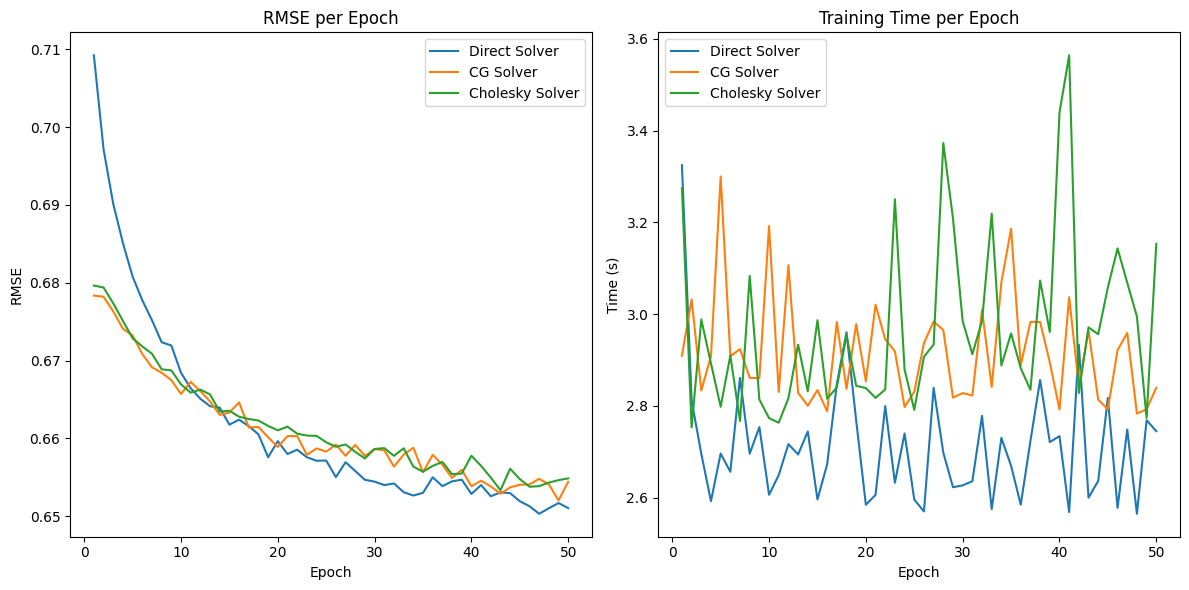

In [5]:
legend_names = ['Direct Solver', 'CG Solver', 'Cholesky Solver']
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs, legend_names)

In [6]:
#max iter 50 CG hutch solve CG fit 
tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

TypeError: plot_results() got an unexpected keyword argument 'tolerance_values'

In [ ]:
# #max iter 50 CG hutch QR fit
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
# plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

In [ ]:
# #max iter 1000 CG hutch QR fit
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
# plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

### CG Fit Testing 


In [7]:

configs = [
    {"solver": "solve", "hutch_solver": "solve","cg_tolerance": 1e-4,"use_qr": True},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-4,"use_qr": False},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-3,"use_qr": False},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-2,"use_qr": False},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-1,"use_qr": False},
    {"solver": "cholesky", "hutch_solver": "solve","use_qr": False},
    {"solver": "solve", "hutch_solver": "solve","use_qr": False},
]
legend_names = ['QR Solve', 'CG Solver 1e-4','CG Solver 1e-3','CG Solver 1e-2','CG Solver 1e-1','Cholesky Solver',"Direct Solver"]

epochs = 50
N = 1 # Number of runs
all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes = benchmark(train_dataset, test_dataset, epochs=epochs, seed=6535, N=N, configs=configs)

  0%|          | 0/6 [00:00<?, ?it/s]

Running model with solver 'solve'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:29,  4.27s/it]

RMSE: 0.7092196345329285 NEG_MLL -23844.45703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5770]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9101, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:19,  4.16s/it]

RMSE: 0.6971422433853149 NEG_MLL -21569.673828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6187]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1537, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:21,  4.29s/it]

RMSE: 0.6901350021362305 NEG_MLL -20076.07421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6288]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.4077, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:16<03:13,  4.21s/it]

RMSE: 0.6850996017456055 NEG_MLL -18876.765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6256]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6694, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
 10%|█         | 5/50 [00:20<03:07,  4.16s/it]

RMSE: 0.6807898283004761 NEG_MLL -17924.6171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6156]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9297, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:01,  4.14s/it]

RMSE: 0.6777558326721191 NEG_MLL -17026.650390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6146]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1944, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:29<03:00,  4.19s/it]

RMSE: 0.6751779317855835 NEG_MLL -16556.88671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5955]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4526, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:33<03:00,  4.30s/it]

RMSE: 0.672351598739624 NEG_MLL -15938.943359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5714]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7125, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:38<02:56,  4.30s/it]

RMSE: 0.671929121017456 NEG_MLL -15446.353515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5590]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9682, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
 20%|██        | 10/50 [00:42<02:51,  4.28s/it]

RMSE: 0.6684255599975586 NEG_MLL -15015.0380859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5478]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2165, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:46<02:46,  4.26s/it]

RMSE: 0.6664420962333679 NEG_MLL -14626.421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5308]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4636, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:50<02:42,  4.27s/it]

RMSE: 0.6650786399841309 NEG_MLL -14262.185546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5172]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7033, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:55<02:35,  4.22s/it]

RMSE: 0.6641272306442261 NEG_MLL -13852.6083984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5138]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9374, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:58<02:27,  4.09s/it]

RMSE: 0.6639472842216492 NEG_MLL -13691.3388671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4972]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1685, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:02<02:17,  3.93s/it]

RMSE: 0.6617622971534729 NEG_MLL -13405.86328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4935]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3953, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:07<02:22,  4.18s/it]

RMSE: 0.6624124050140381 NEG_MLL -13130.365234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4821]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6207, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:11<02:16,  4.12s/it]

RMSE: 0.6615871787071228 NEG_MLL -12881.56640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4828]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8401, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:15<02:12,  4.13s/it]

RMSE: 0.6605178713798523 NEG_MLL -12676.521484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4751]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0560, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:19<02:08,  4.15s/it]

RMSE: 0.6575654149055481 NEG_MLL -12434.677734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4731]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2678, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:23<02:04,  4.14s/it]

RMSE: 0.6596328616142273 NEG_MLL -12255.669921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4759]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.4756, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:27<01:57,  4.04s/it]

RMSE: 0.6579793095588684 NEG_MLL -12063.181640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4751]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.6807, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:31<01:53,  4.06s/it]

RMSE: 0.6585265398025513 NEG_MLL -11915.7578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4609]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8852, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
 46%|████▌     | 23/50 [01:35<01:49,  4.05s/it]

RMSE: 0.6575523614883423 NEG_MLL -11794.0087890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4611]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0856, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:39<01:45,  4.06s/it]

RMSE: 0.6570860147476196 NEG_MLL -11622.759765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4576]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.2863, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:43<01:43,  4.14s/it]

RMSE: 0.6571353673934937 NEG_MLL -11478.3994140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4583]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.4842, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:48<01:39,  4.14s/it]

RMSE: 0.6550162434577942 NEG_MLL -11277.96484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4557]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.6779, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:52<01:35,  4.14s/it]

RMSE: 0.6569159626960754 NEG_MLL -11155.939453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4535]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.8734, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:56<01:32,  4.18s/it]

RMSE: 0.6558030247688293 NEG_MLL -10968.80859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4516]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0654, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:00<01:28,  4.21s/it]

RMSE: 0.6546800136566162 NEG_MLL -10899.37890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4452]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.2533, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:05<01:24,  4.24s/it]

RMSE: 0.6544322967529297 NEG_MLL -10815.515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4411]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.4395, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:09<01:20,  4.24s/it]

RMSE: 0.6540037989616394 NEG_MLL -10657.6181640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4469]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.6259, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:13<01:14,  4.16s/it]

RMSE: 0.6542019844055176 NEG_MLL -10556.8642578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4416]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.8124, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:17<01:09,  4.09s/it]

RMSE: 0.6530945301055908 NEG_MLL -10438.6318359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4358]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.9952, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:21<01:05,  4.10s/it]

RMSE: 0.6526458859443665 NEG_MLL -10291.5048828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4391]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.1821, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:25<01:02,  4.17s/it]

RMSE: 0.652995765209198 NEG_MLL -10229.5966796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4258]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3652, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:29<00:57,  4.11s/it]

RMSE: 0.6550031900405884 NEG_MLL -10078.0927734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4328]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.5509, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:33<00:53,  4.09s/it]

RMSE: 0.653873085975647 NEG_MLL -9984.5771484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4282]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.7315, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:37<00:49,  4.11s/it]

RMSE: 0.6544898748397827 NEG_MLL -9890.658203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4325]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.9123, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:42<00:45,  4.15s/it]

RMSE: 0.654687225818634 NEG_MLL -9847.54296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4179]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.0940, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:46<00:41,  4.15s/it]

RMSE: 0.65284264087677 NEG_MLL -9781.681640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4235]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.2740, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:50<00:37,  4.16s/it]

RMSE: 0.6539965271949768 NEG_MLL -9645.5 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4211]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.4546, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:54<00:33,  4.19s/it]

RMSE: 0.6525500416755676 NEG_MLL -9602.28125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4120]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6334, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [02:58<00:29,  4.21s/it]

RMSE: 0.6530438661575317 NEG_MLL -9502.44921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4166]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.8140, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:02<00:25,  4.17s/it]

RMSE: 0.6529432535171509 NEG_MLL -9454.259765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4161]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.9907, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:06<00:20,  4.12s/it]

RMSE: 0.6519036889076233 NEG_MLL -9317.9140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4130]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.1708, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:11<00:16,  4.13s/it]

RMSE: 0.6512714624404907 NEG_MLL -9250.806640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4118]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.3494, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:14<00:12,  4.04s/it]

RMSE: 0.6502912044525146 NEG_MLL -9128.671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4223]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.5263, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:19<00:08,  4.08s/it]

RMSE: 0.6510187387466431 NEG_MLL -9110.8857421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4133]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.7056, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:23<00:04,  4.12s/it]

RMSE: 0.6516788601875305 NEG_MLL -9029.439453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4116]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.8885, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:27<00:00,  4.15s/it]


RMSE: 0.6510326862335205 NEG_MLL -9000.3291015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4149]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(11.0670, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cg'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:32,  4.33s/it]

RMSE: 0.74602210521698 NEG_MLL -23649.8125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5902]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9001, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:22,  4.22s/it]

RMSE: 0.74596107006073 NEG_MLL -21799.140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5939]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1161, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:16,  4.18s/it]

RMSE: 0.7526068091392517 NEG_MLL -20432.13671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5794]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3419, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:16<03:10,  4.15s/it]

RMSE: 0.7464610934257507 NEG_MLL -19319.171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5598]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5763, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:20<03:07,  4.16s/it]

RMSE: 0.7476703524589539 NEG_MLL -18405.83984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5371]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8148, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:03,  4.16s/it]

RMSE: 0.7469052076339722 NEG_MLL -17630.98046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5254]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0517, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:29<03:01,  4.22s/it]

RMSE: 0.7524737119674683 NEG_MLL -16971.890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5085]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2898, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:33<02:53,  4.14s/it]

RMSE: 0.751660168170929 NEG_MLL -16414.76953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4987]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5216, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:37<02:48,  4.12s/it]

RMSE: 0.7531827092170715 NEG_MLL -15872.080078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4922]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7497, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:41<02:43,  4.09s/it]

RMSE: 0.7515187859535217 NEG_MLL -15427.7724609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4770]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9717, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:45<02:38,  4.06s/it]

RMSE: 0.7684667706489563 NEG_MLL -14977.6982421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4789]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1886, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:49<02:37,  4.14s/it]

RMSE: 0.7701130509376526 NEG_MLL -14623.8251953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4668]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4019, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:54<02:35,  4.21s/it]

RMSE: 0.7591871619224548 NEG_MLL -14335.5087890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4631]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6107, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:58<02:28,  4.12s/it]

RMSE: 0.7608849406242371 NEG_MLL -14025.5234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4615]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8133, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:01<02:21,  4.04s/it]

RMSE: 0.7564968466758728 NEG_MLL -13682.49609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4595]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0166, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:06<02:18,  4.06s/it]

RMSE: 0.7611775994300842 NEG_MLL -13438.7001953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4555]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2123, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:10<02:14,  4.07s/it]

RMSE: 0.7623953819274902 NEG_MLL -13203.794921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4558]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4066, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:14<02:10,  4.09s/it]

RMSE: 0.7618810534477234 NEG_MLL -12978.9208984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4487]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5969, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:18<02:07,  4.11s/it]

RMSE: 0.7632865309715271 NEG_MLL -12728.669921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4455]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7837, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:22<02:02,  4.09s/it]

RMSE: 0.7656408548355103 NEG_MLL -12637.962890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4351]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9680, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:26<01:59,  4.11s/it]

RMSE: 0.7644997239112854 NEG_MLL -12343.24609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4343]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1530, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:30<01:54,  4.09s/it]

RMSE: 0.7729941606521606 NEG_MLL -12242.5546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4290]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.3354, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:35<01:52,  4.17s/it]

RMSE: 0.7792375087738037 NEG_MLL -12105.6845703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4380]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.5149, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:38<01:46,  4.11s/it]

RMSE: 0.7648876905441284 NEG_MLL -11918.5234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4284]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.6947, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:42<01:39,  4.00s/it]

RMSE: 0.7687053084373474 NEG_MLL -11851.005859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4204]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8710, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:46<01:35,  3.99s/it]

RMSE: 0.7765946984291077 NEG_MLL -11609.07421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4364]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0463, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:50<01:32,  4.02s/it]

RMSE: 0.7682541012763977 NEG_MLL -11444.9375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4323]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.2181, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:54<01:29,  4.08s/it]

RMSE: 0.7652196288108826 NEG_MLL -11368.4755859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4246]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.3879, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [01:59<01:25,  4.09s/it]

RMSE: 0.7697315812110901 NEG_MLL -11241.2880859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4315]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.5568, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:03<01:20,  4.04s/it]

RMSE: 0.7712028622627258 NEG_MLL -11139.0302734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4255]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.7256, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:07<01:16,  4.05s/it]

RMSE: 0.7764900326728821 NEG_MLL -10959.068359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4174]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.8948, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:11<01:14,  4.12s/it]

RMSE: 0.7678490281105042 NEG_MLL -10785.7890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4279]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0621, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:15<01:10,  4.17s/it]

RMSE: 0.767738938331604 NEG_MLL -10692.6474609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4244]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.2299, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:19<01:06,  4.16s/it]

RMSE: 0.7713837623596191 NEG_MLL -10601.6103515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4199]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.3951, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:23<01:01,  4.10s/it]

RMSE: 0.7738013863563538 NEG_MLL -10545.859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4157]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.5580, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:27<00:56,  4.07s/it]

RMSE: 0.7722434401512146 NEG_MLL -10404.9541015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4156]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.7238, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:31<00:53,  4.08s/it]

RMSE: 0.7693080902099609 NEG_MLL -10285.4345703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4179]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.8877, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:36<00:49,  4.10s/it]

RMSE: 0.7731610536575317 NEG_MLL -10210.439453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4172]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.0463, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:40<00:45,  4.12s/it]

RMSE: 0.7788965106010437 NEG_MLL -10153.6494140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4203]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.2074, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:44<00:41,  4.13s/it]

RMSE: 0.775580644607544 NEG_MLL -10108.3251953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4156]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3667, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:48<00:36,  4.10s/it]

RMSE: 0.7770830392837524 NEG_MLL -10023.5400390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4181]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.5283, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:52<00:32,  4.10s/it]

RMSE: 0.7825796008110046 NEG_MLL -9853.8681640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4200]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.6918, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [02:56<00:28,  4.13s/it]

RMSE: 0.7749616503715515 NEG_MLL -9868.0029296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4127]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.8526, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:01<00:25,  4.22s/it]

RMSE: 0.7821873426437378 NEG_MLL -9764.7666015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4190]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.0127, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:05<00:21,  4.29s/it]

RMSE: 0.7842745184898376 NEG_MLL -9681.767578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4086]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.1741, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:09<00:16,  4.24s/it]

RMSE: 0.777096152305603 NEG_MLL -9612.931640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4097]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.3344, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:13<00:12,  4.18s/it]

RMSE: 0.7721177339553833 NEG_MLL -9500.1083984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4080]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.4972, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:17<00:08,  4.13s/it]

RMSE: 0.7818781733512878 NEG_MLL -9502.9169921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4134]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6578, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:21<00:04,  4.12s/it]

RMSE: 0.7754564881324768 NEG_MLL -9414.9453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4162]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.8192, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:25<00:00,  4.12s/it]


RMSE: 0.7804489731788635 NEG_MLL -9324.5244140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4076]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.9828, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cg'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:22,  4.13s/it]

RMSE: 0.7578146457672119 NEG_MLL -23596.87109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5828]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9033, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:18,  4.13s/it]

RMSE: 0.7520812153816223 NEG_MLL -21637.00390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5713]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1227, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:16,  4.18s/it]

RMSE: 0.7504333853721619 NEG_MLL -20228.955078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5533]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3515, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:16<03:12,  4.19s/it]

RMSE: 0.7450551986694336 NEG_MLL -19167.412109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5364]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5869, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:21<03:11,  4.26s/it]

RMSE: 0.744096040725708 NEG_MLL -18239.76171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5300]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8232, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:05,  4.22s/it]

RMSE: 0.7448316216468811 NEG_MLL -17436.75 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5123]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0608, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:29<03:01,  4.23s/it]

RMSE: 0.7482928037643433 NEG_MLL -16767.32421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5028]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2959, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:33<02:56,  4.21s/it]

RMSE: 0.7545385360717773 NEG_MLL -16266.453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4882]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5263, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:37<02:51,  4.17s/it]

RMSE: 0.7669140100479126 NEG_MLL -15817.8525390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4778]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7552, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:41<02:47,  4.19s/it]

RMSE: 0.7551190853118896 NEG_MLL -15245.98046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4758]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9776, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:46<02:45,  4.23s/it]

RMSE: 0.7555756568908691 NEG_MLL -14889.083984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4725]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1944, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:50<02:39,  4.19s/it]

RMSE: 0.7553616762161255 NEG_MLL -14510.3330078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4664]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4089, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:54<02:34,  4.17s/it]

RMSE: 0.7705804109573364 NEG_MLL -14252.4443359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4548]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6197, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:58<02:30,  4.17s/it]

RMSE: 0.7577950954437256 NEG_MLL -13941.1904296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4544]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8249, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:03<02:27,  4.23s/it]

RMSE: 0.773789644241333 NEG_MLL -13645.896484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4509]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0249, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:07<02:23,  4.22s/it]

RMSE: 0.7572247982025146 NEG_MLL -13358.35546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4544]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2249, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:11<02:16,  4.15s/it]

RMSE: 0.763822078704834 NEG_MLL -13106.259765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4487]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4175, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:15<02:12,  4.13s/it]

RMSE: 0.7613632678985596 NEG_MLL -12875.6337890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4428]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6095, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:19<02:07,  4.10s/it]

RMSE: 0.7611178159713745 NEG_MLL -12655.2890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4429]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7958, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:23<02:05,  4.17s/it]

RMSE: 0.763332188129425 NEG_MLL -12507.212890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4394]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9806, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:27<02:01,  4.20s/it]

RMSE: 0.7675246000289917 NEG_MLL -12342.4013671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4454]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1626, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:32<01:56,  4.17s/it]

RMSE: 0.7781155705451965 NEG_MLL -12094.5 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4457]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.3446, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:36<01:53,  4.19s/it]

RMSE: 0.7663440704345703 NEG_MLL -11953.328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4370]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.5223, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:40<01:47,  4.15s/it]

RMSE: 0.7672522664070129 NEG_MLL -11802.6162109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4301]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.6978, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:44<01:44,  4.18s/it]

RMSE: 0.7775012850761414 NEG_MLL -11635.708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4349]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8730, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:48<01:40,  4.20s/it]

RMSE: 0.7672609090805054 NEG_MLL -11622.1025390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4274]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0456, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:52<01:34,  4.13s/it]

RMSE: 0.7683992385864258 NEG_MLL -11422.2353515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4280]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.2227, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:57<01:31,  4.16s/it]

RMSE: 0.7706181406974792 NEG_MLL -11285.6728515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4317]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.3941, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:00<01:25,  4.08s/it]

RMSE: 0.7680699229240417 NEG_MLL -11199.2783203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4273]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.5656, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:05<01:22,  4.10s/it]

RMSE: 0.7798401117324829 NEG_MLL -11084.9501953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4265]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.7369, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:09<01:17,  4.09s/it]

RMSE: 0.7678296566009521 NEG_MLL -10960.126953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4231]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.9058, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:13<01:14,  4.14s/it]

RMSE: 0.7644413113594055 NEG_MLL -10808.2578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4257]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0740, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:17<01:10,  4.15s/it]

RMSE: 0.7724931240081787 NEG_MLL -10757.1953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4235]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.2419, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:21<01:06,  4.17s/it]

RMSE: 0.7755743861198425 NEG_MLL -10680.966796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4199]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.4083, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:25<01:01,  4.13s/it]

RMSE: 0.774921715259552 NEG_MLL -10515.7802734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4273]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.5747, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:29<00:57,  4.14s/it]

RMSE: 0.7772362232208252 NEG_MLL -10424.2509765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4164]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.7415, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:34<00:54,  4.17s/it]

RMSE: 0.7732341885566711 NEG_MLL -10362.265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4167]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.9063, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:38<00:49,  4.12s/it]

RMSE: 0.7746983766555786 NEG_MLL -10219.759765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4191]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.0717, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:42<00:44,  4.03s/it]

RMSE: 0.7745599150657654 NEG_MLL -10167.2958984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4192]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.2331, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:46<00:40,  4.06s/it]

RMSE: 0.7760971188545227 NEG_MLL -10070.6474609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4100]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3988, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:50<00:37,  4.14s/it]

RMSE: 0.781181812286377 NEG_MLL -10010.021484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4119]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.5634, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:54<00:33,  4.15s/it]

RMSE: 0.7800734639167786 NEG_MLL -9926.4169921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4120]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.7229, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [02:58<00:28,  4.12s/it]

RMSE: 0.7772983312606812 NEG_MLL -9830.9912109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4071]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.8840, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:02<00:24,  4.15s/it]

RMSE: 0.7751116752624512 NEG_MLL -9720.7451171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4050]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.0472, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:06<00:20,  4.10s/it]

RMSE: 0.785149335861206 NEG_MLL -9663.392578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4131]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.2084, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:11<00:16,  4.09s/it]

RMSE: 0.7870229482650757 NEG_MLL -9598.98828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4215]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.3696, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:15<00:12,  4.12s/it]

RMSE: 0.7872189283370972 NEG_MLL -9558.431640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4046]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.5327, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:19<00:08,  4.14s/it]

RMSE: 0.7793856263160706 NEG_MLL -9499.5654296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4183]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6945, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:23<00:04,  4.14s/it]

RMSE: 0.7804564237594604 NEG_MLL -9398.59765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4119]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.8573, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:27<00:00,  4.15s/it]


RMSE: 0.7797090411186218 NEG_MLL -9264.55859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4079]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(10.0194, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cg'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:19,  4.07s/it]

RMSE: 0.7529531121253967 NEG_MLL -23489.22265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5839]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9032, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:14,  4.05s/it]

RMSE: 0.7357271313667297 NEG_MLL -21584.12109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5723]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1210, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:15,  4.15s/it]

RMSE: 0.7507127523422241 NEG_MLL -20197.828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5544]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3499, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:16<03:14,  4.23s/it]

RMSE: 0.7475494742393494 NEG_MLL -19139.912109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5353]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5818, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:20<03:09,  4.22s/it]

RMSE: 0.7459478974342346 NEG_MLL -18204.236328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5233]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8223, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:05,  4.21s/it]

RMSE: 0.7470883727073669 NEG_MLL -17457.23828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5059]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0594, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:29<03:01,  4.21s/it]

RMSE: 0.7484681010246277 NEG_MLL -16826.263671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4964]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2966, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:33<02:55,  4.18s/it]

RMSE: 0.7523045539855957 NEG_MLL -16287.625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4915]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5301, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:37<02:47,  4.09s/it]

RMSE: 0.7525120973587036 NEG_MLL -15726.5732421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4823]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7587, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:41<02:45,  4.14s/it]

RMSE: 0.759787917137146 NEG_MLL -15350.337890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4699]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9805, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:45<02:41,  4.14s/it]

RMSE: 0.7658684253692627 NEG_MLL -14860.00390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4673]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1981, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:49<02:35,  4.10s/it]

RMSE: 0.7567588686943054 NEG_MLL -14477.51171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4633]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4136, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:53<02:31,  4.09s/it]

RMSE: 0.7588798403739929 NEG_MLL -14180.4130859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4532]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6240, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:57<02:27,  4.10s/it]

RMSE: 0.7578095197677612 NEG_MLL -13849.1328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4544]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8274, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:02<02:24,  4.12s/it]

RMSE: 0.7617023587226868 NEG_MLL -13596.1796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4521]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0285, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:06<02:20,  4.13s/it]

RMSE: 0.757681667804718 NEG_MLL -13297.7578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4399]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2259, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:10<02:17,  4.18s/it]

RMSE: 0.7654061913490295 NEG_MLL -13091.708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4386]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4199, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:14<02:11,  4.12s/it]

RMSE: 0.763035237789154 NEG_MLL -12899.603515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4370]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6110, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:18<02:05,  4.06s/it]

RMSE: 0.7640231251716614 NEG_MLL -12677.890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4378]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7991, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:22<02:01,  4.06s/it]

RMSE: 0.7637813091278076 NEG_MLL -12472.55078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4342]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9839, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:26<01:59,  4.13s/it]

RMSE: 0.7663925886154175 NEG_MLL -12313.2373046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4325]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1653, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:30<01:54,  4.10s/it]

RMSE: 0.7635365724563599 NEG_MLL -12139.9716796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4334]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.3475, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:34<01:50,  4.09s/it]

RMSE: 0.7672046422958374 NEG_MLL -12007.90234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4331]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.5266, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:38<01:46,  4.09s/it]

RMSE: 0.7669254541397095 NEG_MLL -11906.7353515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4314]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.7036, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:43<01:42,  4.11s/it]

RMSE: 0.7679938673973083 NEG_MLL -11734.7744140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4297]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8796, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:47<01:39,  4.16s/it]

RMSE: 0.7697356343269348 NEG_MLL -11567.5634765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4333]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0531, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:51<01:35,  4.17s/it]

RMSE: 0.7696542739868164 NEG_MLL -11430.029296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4247]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.2245, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:55<01:31,  4.18s/it]

RMSE: 0.7727276682853699 NEG_MLL -11326.2724609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4254]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.3946, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:00<01:28,  4.19s/it]

RMSE: 0.7707522511482239 NEG_MLL -11185.66015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4217]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.5675, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:04<01:23,  4.18s/it]

RMSE: 0.7742729187011719 NEG_MLL -11054.4267578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4216]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.7362, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:08<01:20,  4.24s/it]

RMSE: 0.7723415493965149 NEG_MLL -10912.484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4284]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.9064, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:12<01:15,  4.22s/it]

RMSE: 0.7725962400436401 NEG_MLL -10814.2041015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4234]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0709, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:16<01:10,  4.17s/it]

RMSE: 0.7747625708580017 NEG_MLL -10752.7900390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4197]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.2376, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:21<01:07,  4.20s/it]

RMSE: 0.7768460512161255 NEG_MLL -10592.7373046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4244]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.4034, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:25<01:02,  4.17s/it]

RMSE: 0.7749017477035522 NEG_MLL -10512.9189453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4265]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.5667, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:29<00:58,  4.16s/it]

RMSE: 0.7743563055992126 NEG_MLL -10432.1689453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4179]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.7310, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:33<00:54,  4.17s/it]

RMSE: 0.7757900953292847 NEG_MLL -10294.966796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4171]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.8926, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:37<00:49,  4.16s/it]

RMSE: 0.772140383720398 NEG_MLL -10207.990234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4160]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.0572, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:41<00:45,  4.11s/it]

RMSE: 0.7748317718505859 NEG_MLL -10138.7294921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4195]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.2186, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:45<00:41,  4.11s/it]

RMSE: 0.7761991620063782 NEG_MLL -10068.2783203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4177]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3777, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:49<00:36,  4.09s/it]

RMSE: 0.7749243378639221 NEG_MLL -9993.671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4189]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.5385, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:53<00:33,  4.13s/it]

RMSE: 0.7776129841804504 NEG_MLL -9874.87109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4231]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.7007, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [02:58<00:28,  4.11s/it]

RMSE: 0.7774777412414551 NEG_MLL -9822.5419921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4100]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.8614, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:02<00:24,  4.11s/it]

RMSE: 0.7778218388557434 NEG_MLL -9801.314453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4127]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.0231, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:06<00:20,  4.16s/it]

RMSE: 0.7775149941444397 NEG_MLL -9657.966796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4095]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.1843, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:10<00:16,  4.13s/it]

RMSE: 0.782355010509491 NEG_MLL -9584.837890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4107]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.3471, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:14<00:12,  4.16s/it]

RMSE: 0.7808564305305481 NEG_MLL -9514.28515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4087]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.5078, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:18<00:08,  4.12s/it]

RMSE: 0.7843725681304932 NEG_MLL -9447.0703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4124]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6651, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:22<00:04,  4.10s/it]

RMSE: 0.7808910012245178 NEG_MLL -9340.607421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4105]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.8259, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:26<00:00,  4.14s/it]


RMSE: 0.7810289859771729 NEG_MLL -9297.3212890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4065]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.9832, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cg'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:17,  4.03s/it]

RMSE: 0.7581617832183838 NEG_MLL -23496.58984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5811]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9007, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:24,  4.27s/it]

RMSE: 0.7460722327232361 NEG_MLL -21581.060546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5711]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1181, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:17,  4.19s/it]

RMSE: 0.7514158487319946 NEG_MLL -20190.80859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5563]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3436, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:16<03:11,  4.16s/it]

RMSE: 0.744981586933136 NEG_MLL -19132.767578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5351]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5770, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:20<03:06,  4.15s/it]

RMSE: 0.7445140480995178 NEG_MLL -18180.296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5245]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8130, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:24<03:00,  4.11s/it]

RMSE: 0.7588736414909363 NEG_MLL -17392.861328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5084]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0466, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:29<03:00,  4.19s/it]

RMSE: 0.7469931840896606 NEG_MLL -16812.921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4984]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2822, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:33<02:57,  4.22s/it]

RMSE: 0.750489354133606 NEG_MLL -16226.97265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4879]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5137, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:37<02:49,  4.13s/it]

RMSE: 0.7542165517807007 NEG_MLL -15776.84765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4761]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7359, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:41<02:42,  4.06s/it]

RMSE: 0.7559239268302917 NEG_MLL -15296.3369140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4687]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9546, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:45<02:37,  4.04s/it]

RMSE: 0.7562533617019653 NEG_MLL -14824.2275390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4712]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1734, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:49<02:35,  4.10s/it]

RMSE: 0.7565341591835022 NEG_MLL -14495.798828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4629]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3850, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:53<02:31,  4.09s/it]

RMSE: 0.7627921104431152 NEG_MLL -14222.7646484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4565]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5924, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:57<02:27,  4.10s/it]

RMSE: 0.7624420523643494 NEG_MLL -13880.103515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4510]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7967, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:01<02:22,  4.08s/it]

RMSE: 0.7612144351005554 NEG_MLL -13609.7666015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4475]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9976, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:05<02:18,  4.09s/it]

RMSE: 0.7616926431655884 NEG_MLL -13404.33203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4467]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1947, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:09<02:13,  4.05s/it]

RMSE: 0.76372891664505 NEG_MLL -13114.857421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4391]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3902, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:14<02:11,  4.10s/it]

RMSE: 0.7616384029388428 NEG_MLL -12925.7021484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4374]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5814, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:18<02:06,  4.09s/it]

RMSE: 0.7604160308837891 NEG_MLL -12670.427734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4396]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7699, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:22<02:03,  4.10s/it]

RMSE: 0.7615430355072021 NEG_MLL -12538.48046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4358]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9537, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:26<01:59,  4.11s/it]

RMSE: 0.7652236819267273 NEG_MLL -12370.4033203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4392]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1355, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:30<01:55,  4.13s/it]

RMSE: 0.7622585892677307 NEG_MLL -12118.4833984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4364]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.3149, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:34<01:52,  4.17s/it]

RMSE: 0.7631807327270508 NEG_MLL -11895.306640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4347]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.4916, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:38<01:47,  4.13s/it]

RMSE: 0.7717128396034241 NEG_MLL -11827.5244140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4332]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.6662, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:42<01:42,  4.12s/it]

RMSE: 0.7674400806427002 NEG_MLL -11707.94921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4297]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8390, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:46<01:38,  4.08s/it]

RMSE: 0.7728018760681152 NEG_MLL -11628.6640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4166]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0117, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:51<01:35,  4.14s/it]

RMSE: 0.764961838722229 NEG_MLL -11384.197265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4241]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.1863, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:55<01:32,  4.21s/it]

RMSE: 0.7708876729011536 NEG_MLL -11270.83984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4255]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.3552, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [01:59<01:27,  4.15s/it]

RMSE: 0.7687421441078186 NEG_MLL -11199.4052734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4189]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.5226, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:03<01:22,  4.13s/it]

RMSE: 0.7806403636932373 NEG_MLL -11014.041015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4235]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.6882, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:07<01:17,  4.10s/it]

RMSE: 0.7706094980239868 NEG_MLL -10943.849609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4239]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.8561, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:11<01:14,  4.12s/it]

RMSE: 0.7735913991928101 NEG_MLL -10847.029296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4187]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0215, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:16<01:10,  4.12s/it]

RMSE: 0.7704877853393555 NEG_MLL -10710.79296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4219]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.1840, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:20<01:07,  4.20s/it]

RMSE: 0.7702957987785339 NEG_MLL -10606.279296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4222]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.3469, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:24<01:03,  4.20s/it]

RMSE: 0.7721664309501648 NEG_MLL -10543.365234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4108]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.5107, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:28<00:58,  4.18s/it]

RMSE: 0.7708712816238403 NEG_MLL -10438.19140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4124]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.6743, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:32<00:53,  4.14s/it]

RMSE: 0.7726750373840332 NEG_MLL -10347.076171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4153]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.8367, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:36<00:48,  4.05s/it]

RMSE: 0.7758874893188477 NEG_MLL -10265.25390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4137]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.9974, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:41<00:45,  4.16s/it]

RMSE: 0.7757793068885803 NEG_MLL -10110.6328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4130]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.1600, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:44<00:40,  4.10s/it]

RMSE: 0.777878999710083 NEG_MLL -10062.0810546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4099]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3190, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:49<00:36,  4.07s/it]

RMSE: 0.7741559147834778 NEG_MLL -9979.916015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4066]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.4821, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:53<00:32,  4.08s/it]

RMSE: 0.7747226357460022 NEG_MLL -9909.0029296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4220]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.6437, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [02:57<00:28,  4.03s/it]

RMSE: 0.775068461894989 NEG_MLL -9792.876953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4141]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.8053, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:01<00:24,  4.11s/it]

RMSE: 0.7743621468544006 NEG_MLL -9713.0888671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4047]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.9661, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:05<00:20,  4.11s/it]

RMSE: 0.7840797901153564 NEG_MLL -9663.4970703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4159]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.1263, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:09<00:16,  4.09s/it]

RMSE: 0.7752537131309509 NEG_MLL -9516.4384765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4089]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.2867, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:13<00:12,  4.09s/it]

RMSE: 0.7784583568572998 NEG_MLL -9473.185546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4080]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.4481, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:17<00:08,  4.13s/it]

RMSE: 0.7803319096565247 NEG_MLL -9470.3056640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4015]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6084, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:21<00:04,  4.11s/it]

RMSE: 0.7797666788101196 NEG_MLL -9387.0986328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4059]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.7671, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:26<00:00,  4.12s/it]


RMSE: 0.7802569270133972 NEG_MLL -9314.82421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4167]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.9289, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cholesky'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  2%|▏         | 1/50 [00:04<03:19,  4.06s/it]

RMSE: 0.7051777243614197 NEG_MLL -23484.640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5819]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9002, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  4%|▍         | 2/50 [00:08<03:18,  4.14s/it]

RMSE: 0.7023499608039856 NEG_MLL -21462.0625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5717]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1179, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  6%|▌         | 3/50 [00:12<03:13,  4.12s/it]

RMSE: 0.7011091709136963 NEG_MLL -20203.951171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5533]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3446, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  8%|▊         | 4/50 [00:16<03:10,  4.14s/it]

RMSE: 0.6990725994110107 NEG_MLL -19074.25390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5361]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5806, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 10%|█         | 5/50 [00:20<03:09,  4.20s/it]

RMSE: 0.7005026340484619 NEG_MLL -18240.5390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5215]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8165, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 12%|█▏        | 6/50 [00:24<03:03,  4.16s/it]

RMSE: 0.7014570832252502 NEG_MLL -17435.626953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5104]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0533, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 14%|█▍        | 7/50 [00:29<02:58,  4.14s/it]

RMSE: 0.6996766328811646 NEG_MLL -16755.9453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4970]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2896, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 16%|█▌        | 8/50 [00:33<02:53,  4.14s/it]

RMSE: 0.6991669535636902 NEG_MLL -16206.1513671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4871]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5182, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 18%|█▊        | 9/50 [00:37<02:47,  4.09s/it]

RMSE: 0.7000517249107361 NEG_MLL -15715.35546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4797]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7405, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 20%|██        | 10/50 [00:41<02:42,  4.06s/it]

RMSE: 0.70160973072052 NEG_MLL -15245.505859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4714]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9607, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 22%|██▏       | 11/50 [00:45<02:42,  4.16s/it]

RMSE: 0.7025057077407837 NEG_MLL -14826.654296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4651]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1793, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 24%|██▍       | 12/50 [00:49<02:37,  4.16s/it]

RMSE: 0.7043684720993042 NEG_MLL -14488.529296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4608]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3925, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 26%|██▌       | 13/50 [00:53<02:33,  4.14s/it]

RMSE: 0.7041226625442505 NEG_MLL -14227.2900390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4535]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6061, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 28%|██▊       | 14/50 [00:57<02:29,  4.17s/it]

RMSE: 0.704704225063324 NEG_MLL -13941.810546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4481]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8086, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 30%|███       | 15/50 [01:02<02:24,  4.14s/it]

RMSE: 0.7039388418197632 NEG_MLL -13642.8935546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4495]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0094, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 32%|███▏      | 16/50 [01:06<02:21,  4.16s/it]

RMSE: 0.7085141539573669 NEG_MLL -13394.3466796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4470]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2088, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 34%|███▍      | 17/50 [01:10<02:16,  4.14s/it]

RMSE: 0.7117789387702942 NEG_MLL -13184.021484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4478]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4041, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 36%|███▌      | 18/50 [01:14<02:11,  4.12s/it]

RMSE: 0.7121379375457764 NEG_MLL -12986.6904296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4403]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5947, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 38%|███▊      | 19/50 [01:18<02:08,  4.15s/it]

RMSE: 0.70712810754776 NEG_MLL -12720.529296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4434]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7846, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 40%|████      | 20/50 [01:22<02:04,  4.16s/it]

RMSE: 0.7125179767608643 NEG_MLL -12520.2587890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4351]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9716, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 42%|████▏     | 21/50 [01:27<02:01,  4.18s/it]

RMSE: 0.7149507403373718 NEG_MLL -12336.6474609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4403]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1522, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 44%|████▍     | 22/50 [01:31<01:57,  4.20s/it]

RMSE: 0.7137598991394043 NEG_MLL -12138.3876953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4331]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.3309, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 46%|████▌     | 23/50 [01:35<01:53,  4.19s/it]

RMSE: 0.715202808380127 NEG_MLL -12020.8203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4321]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.5115, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 48%|████▊     | 24/50 [01:39<01:47,  4.15s/it]

RMSE: 0.7119572162628174 NEG_MLL -11858.8193359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4285]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.6891, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 50%|█████     | 25/50 [01:43<01:44,  4.19s/it]

RMSE: 0.7118710875511169 NEG_MLL -11719.12890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4261]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8674, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 52%|█████▏    | 26/50 [01:48<01:40,  4.21s/it]

RMSE: 0.7166739702224731 NEG_MLL -11611.994140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4299]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0414, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 54%|█████▍    | 27/50 [01:52<01:37,  4.25s/it]

RMSE: 0.7190360426902771 NEG_MLL -11478.3310546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4280]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.2123, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 56%|█████▌    | 28/50 [01:56<01:33,  4.25s/it]

RMSE: 0.7199442386627197 NEG_MLL -11316.125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4211]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.3857, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 58%|█████▊    | 29/50 [02:00<01:28,  4.23s/it]

RMSE: 0.7194873094558716 NEG_MLL -11135.533203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4212]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.5561, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 60%|██████    | 30/50 [02:04<01:24,  4.20s/it]

RMSE: 0.7203627824783325 NEG_MLL -11062.7158203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4140]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.7249, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 62%|██████▏   | 31/50 [02:09<01:19,  4.17s/it]

RMSE: 0.7195865511894226 NEG_MLL -10975.9560546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4204]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.8931, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 64%|██████▍   | 32/50 [02:13<01:16,  4.22s/it]

RMSE: 0.7228463292121887 NEG_MLL -10813.4794921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4258]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0598, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 66%|██████▌   | 33/50 [02:17<01:11,  4.23s/it]

RMSE: 0.7230513691902161 NEG_MLL -10744.1533203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4205]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.2269, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 68%|██████▊   | 34/50 [02:21<01:08,  4.25s/it]

RMSE: 0.7202291488647461 NEG_MLL -10631.4228515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4135]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.3909, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 70%|███████   | 35/50 [02:26<01:04,  4.27s/it]

RMSE: 0.7254984378814697 NEG_MLL -10503.91796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4128]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.5551, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 72%|███████▏  | 36/50 [02:30<01:00,  4.29s/it]

RMSE: 0.7247489094734192 NEG_MLL -10416.0615234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4123]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.7182, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 74%|███████▍  | 37/50 [02:34<00:55,  4.26s/it]

RMSE: 0.7259190678596497 NEG_MLL -10390.5244140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4052]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.8820, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 76%|███████▌  | 38/50 [02:38<00:50,  4.23s/it]

RMSE: 0.7277183532714844 NEG_MLL -10294.771484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4173]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.0458, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 78%|███████▊  | 39/50 [02:43<00:46,  4.21s/it]

RMSE: 0.721390426158905 NEG_MLL -10118.6015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4125]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.2067, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 80%|████████  | 40/50 [02:47<00:41,  4.16s/it]

RMSE: 0.7280538082122803 NEG_MLL -10081.9521484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4087]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3669, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 82%|████████▏ | 41/50 [02:51<00:36,  4.11s/it]

RMSE: 0.7323862910270691 NEG_MLL -9981.6171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4188]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.5280, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 84%|████████▍ | 42/50 [02:55<00:32,  4.10s/it]

RMSE: 0.7263761758804321 NEG_MLL -9904.05078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4053]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.6903, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 86%|████████▌ | 43/50 [02:59<00:29,  4.19s/it]

RMSE: 0.7251977920532227 NEG_MLL -9791.087890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4096]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.8509, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 88%|████████▊ | 44/50 [03:03<00:24,  4.16s/it]

RMSE: 0.7254443168640137 NEG_MLL -9705.931640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4067]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.0127, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 90%|█████████ | 45/50 [03:07<00:20,  4.15s/it]

RMSE: 0.7285980582237244 NEG_MLL -9657.0078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4069]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.1737, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 92%|█████████▏| 46/50 [03:11<00:16,  4.14s/it]

RMSE: 0.7316184639930725 NEG_MLL -9578.5546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4095]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.3339, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 94%|█████████▍| 47/50 [03:16<00:12,  4.15s/it]

RMSE: 0.7337549924850464 NEG_MLL -9504.140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4019]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.4941, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 96%|█████████▌| 48/50 [03:20<00:08,  4.18s/it]

RMSE: 0.729563295841217 NEG_MLL -9445.8076171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4099]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6558, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 98%|█████████▊| 49/50 [03:24<00:04,  4.13s/it]

RMSE: 0.7311272621154785 NEG_MLL -9390.515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4044]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.8156, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


100%|██████████| 50/50 [03:28<00:00,  4.18s/it]


RMSE: 0.7365444302558899 NEG_MLL -9309.7568359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4077]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.9779, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'solve'
cuda:1
cuda:1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  2%|▏         | 1/50 [00:04<03:23,  4.15s/it]

RMSE: 0.7092841267585754 NEG_MLL -23543.48046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5785]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.9017, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  4%|▍         | 2/50 [00:08<03:20,  4.18s/it]

RMSE: 0.7036899328231812 NEG_MLL -21506.927734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5702]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1195, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  6%|▌         | 3/50 [00:12<03:19,  4.25s/it]

RMSE: 0.7015754580497742 NEG_MLL -20215.1796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5555]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3456, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  8%|▊         | 4/50 [00:17<03:18,  4.30s/it]

RMSE: 0.6997696161270142 NEG_MLL -19168.9609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5359]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5779, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 10%|█         | 5/50 [00:21<03:13,  4.29s/it]

RMSE: 0.6994110941886902 NEG_MLL -18236.2265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5203]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8163, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 12%|█▏        | 6/50 [00:25<03:07,  4.26s/it]

RMSE: 0.7006563544273376 NEG_MLL -17530.515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5107]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0495, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 14%|█▍        | 7/50 [00:29<03:03,  4.27s/it]

RMSE: 0.6957821846008301 NEG_MLL -16825.716796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4948]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2854, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 16%|█▌        | 8/50 [00:34<02:58,  4.25s/it]

RMSE: 0.6988503932952881 NEG_MLL -16175.0576171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4880]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5146, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 18%|█▊        | 9/50 [00:38<02:56,  4.31s/it]

RMSE: 0.6984724402427673 NEG_MLL -15718.1162109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4818]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7402, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 20%|██        | 10/50 [00:42<02:51,  4.30s/it]

RMSE: 0.698453962802887 NEG_MLL -15305.95703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4740]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9636, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 22%|██▏       | 11/50 [00:46<02:46,  4.26s/it]

RMSE: 0.7017706632614136 NEG_MLL -14922.708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4623]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1789, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 24%|██▍       | 12/50 [00:51<02:40,  4.23s/it]

RMSE: 0.6999134421348572 NEG_MLL -14580.306640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4588]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3903, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 26%|██▌       | 13/50 [00:55<02:34,  4.17s/it]

RMSE: 0.7037442922592163 NEG_MLL -14241.205078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4564]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5974, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 28%|██▊       | 14/50 [00:59<02:32,  4.23s/it]

RMSE: 0.7038373351097107 NEG_MLL -13954.5146484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4523]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8009, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 30%|███       | 15/50 [01:03<02:27,  4.20s/it]

RMSE: 0.7052856683731079 NEG_MLL -13671.5703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4466]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0000, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 32%|███▏      | 16/50 [01:07<02:22,  4.20s/it]

RMSE: 0.7053666710853577 NEG_MLL -13377.7939453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4402]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1972, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 34%|███▍      | 17/50 [01:12<02:19,  4.24s/it]

RMSE: 0.709713339805603 NEG_MLL -13187.05859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4391]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3917, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 36%|███▌      | 18/50 [01:16<02:12,  4.15s/it]

RMSE: 0.7107565402984619 NEG_MLL -12930.9384765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4396]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5833, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 38%|███▊      | 19/50 [01:20<02:10,  4.22s/it]

RMSE: 0.7093504071235657 NEG_MLL -12733.982421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4294]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7709, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 40%|████      | 20/50 [01:24<02:05,  4.19s/it]

RMSE: 0.7068056464195251 NEG_MLL -12572.8037109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4240]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9572, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 42%|████▏     | 21/50 [01:28<02:00,  4.17s/it]

RMSE: 0.7148234844207764 NEG_MLL -12353.6416015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4315]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1407, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 44%|████▍     | 22/50 [01:32<01:57,  4.18s/it]

RMSE: 0.7124191522598267 NEG_MLL -12232.2666015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4306]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.3184, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 46%|████▌     | 23/50 [01:37<01:53,  4.20s/it]

RMSE: 0.7134835124015808 NEG_MLL -11981.880859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4361]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.4987, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 48%|████▊     | 24/50 [01:41<01:49,  4.21s/it]

RMSE: 0.7133547067642212 NEG_MLL -11803.8740234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4376]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.6757, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 50%|█████     | 25/50 [01:45<01:45,  4.23s/it]

RMSE: 0.7109569907188416 NEG_MLL -11705.0966796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4284]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.8492, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 52%|█████▏    | 26/50 [01:49<01:41,  4.22s/it]

RMSE: 0.7138769626617432 NEG_MLL -11585.103515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4301]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.0197, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 54%|█████▍    | 27/50 [01:54<01:37,  4.26s/it]

RMSE: 0.7137503623962402 NEG_MLL -11416.048828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4219]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.1955, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 56%|█████▌    | 28/50 [01:58<01:33,  4.25s/it]

RMSE: 0.7214775681495667 NEG_MLL -11298.3984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4262]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.3652, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 58%|█████▊    | 29/50 [02:02<01:28,  4.21s/it]

RMSE: 0.7210676670074463 NEG_MLL -11259.3681640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4135]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.5370, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 60%|██████    | 30/50 [02:06<01:24,  4.22s/it]

RMSE: 0.7233558893203735 NEG_MLL -11074.640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4182]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.7033, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 62%|██████▏   | 31/50 [02:11<01:21,  4.27s/it]

RMSE: 0.722152054309845 NEG_MLL -10988.248046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4137]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(6.8722, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 64%|██████▍   | 32/50 [02:15<01:16,  4.27s/it]

RMSE: 0.7197961211204529 NEG_MLL -10862.0361328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4185]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.0392, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 66%|██████▌   | 33/50 [02:19<01:12,  4.25s/it]

RMSE: 0.7236873507499695 NEG_MLL -10746.982421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4164]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.2016, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 68%|██████▊   | 34/50 [02:23<01:07,  4.24s/it]

RMSE: 0.7297441363334656 NEG_MLL -10692.62109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4224]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.3665, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 70%|███████   | 35/50 [02:27<01:03,  4.20s/it]

RMSE: 0.7300691604614258 NEG_MLL -10571.39453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4172]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.5314, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 72%|███████▏  | 36/50 [02:32<00:59,  4.23s/it]

RMSE: 0.7231078743934631 NEG_MLL -10449.2626953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4195]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.6954, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 74%|███████▍  | 37/50 [02:36<00:54,  4.23s/it]

RMSE: 0.7250562906265259 NEG_MLL -10361.6044921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4180]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(7.8610, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 76%|███████▌  | 38/50 [02:40<00:49,  4.16s/it]

RMSE: 0.7286983728408813 NEG_MLL -10306.1640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4156]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.0235, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 78%|███████▊  | 39/50 [02:44<00:45,  4.16s/it]

RMSE: 0.7276808023452759 NEG_MLL -10189.939453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4143]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.1877, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 80%|████████  | 40/50 [02:48<00:41,  4.17s/it]

RMSE: 0.7315918803215027 NEG_MLL -10108.251953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4172]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.3481, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 82%|████████▏ | 41/50 [02:53<00:38,  4.22s/it]

RMSE: 0.7344202995300293 NEG_MLL -10040.3759765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4109]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.5083, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 84%|████████▍ | 42/50 [02:57<00:34,  4.26s/it]

RMSE: 0.7348368167877197 NEG_MLL -9885.439453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4203]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.6685, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 86%|████████▌ | 43/50 [03:01<00:29,  4.17s/it]

RMSE: 0.7368752360343933 NEG_MLL -9858.7119140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4079]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.8321, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 88%|████████▊ | 44/50 [03:05<00:25,  4.18s/it]

RMSE: 0.7333893775939941 NEG_MLL -9702.57421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4084]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(8.9956, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 90%|█████████ | 45/50 [03:09<00:21,  4.21s/it]

RMSE: 0.7333890199661255 NEG_MLL -9676.32421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4071]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.1514, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 92%|█████████▏| 46/50 [03:14<00:16,  4.17s/it]

RMSE: 0.7365718483924866 NEG_MLL -9631.1767578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4045]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.3095, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 94%|█████████▍| 47/50 [03:18<00:12,  4.23s/it]

RMSE: 0.7326002717018127 NEG_MLL -9461.28515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4120]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.4724, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 96%|█████████▌| 48/50 [03:22<00:08,  4.22s/it]

RMSE: 0.7391729354858398 NEG_MLL -9456.17578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4031]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.6339, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 98%|█████████▊| 49/50 [03:26<00:04,  4.21s/it]

RMSE: 0.735816478729248 NEG_MLL -9335.5966796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4133]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.7922, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


100%|██████████| 50/50 [03:30<00:00,  4.22s/it]

RMSE: 0.7347514629364014 NEG_MLL -9267.4150390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4118]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(9.9514, grad_fn=<ToCopyBackward0>)
eval finished


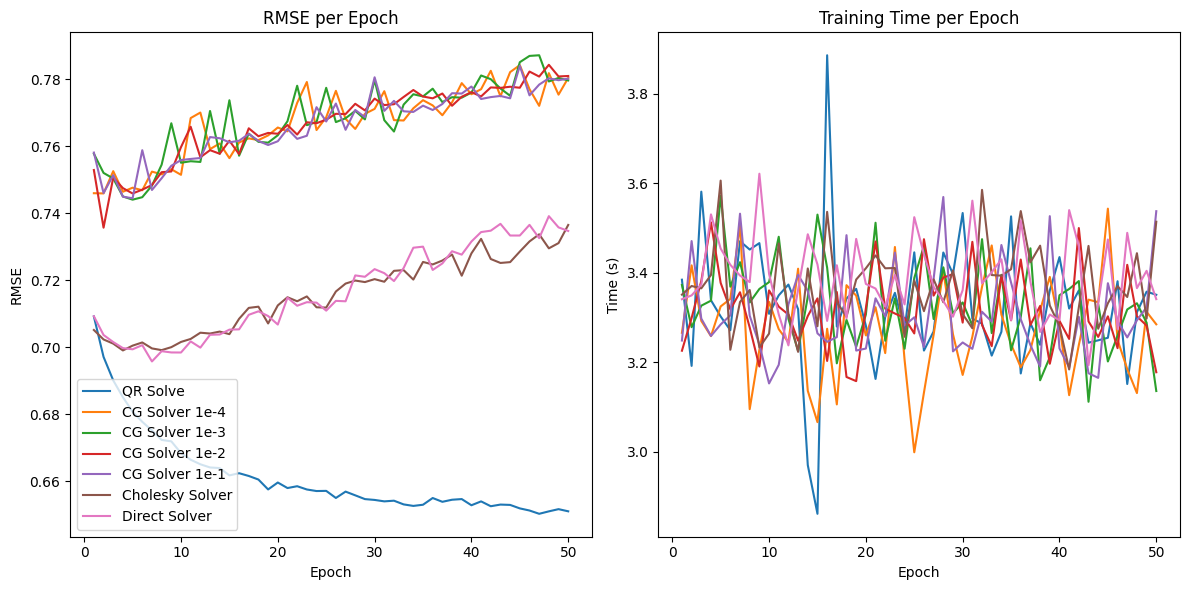

In [18]:
legend_names = ['QR Solve', 'CG Solver 1e-4','CG Solver 1e-3','CG Solver 1e-2','CG Solver 1e-1','Cholesky Solver',"Direct Solver"]
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs, legend_names)